In [1]:
import pandas as pd
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

import matplotlib.pyplot as plt
import gmaps
import gmaps.datasets
import gmaps.geojson_geometries
import pycountry
import numpy as np
from scipy.stats import linregress

from config_sw import api_key

gmaps.configure(api_key=api_key)
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')

In [2]:
# world health report
whr_2015 = pd.read_csv('../Resources/whr_2015_cleaned.csv')
whr_2016 = pd.read_csv('../Resources/whr_2016_cleaned.csv')
# whr_2017 = pd.read_csv('Resources/whr_2017_cleaned.csv')

# World Health Organization Suicide Summary
who_sum = pd.read_csv('../Resources/who_suicide_summary(country codes).csv')

In [3]:
whr_2015_trimmed = whr_2015[['Country', 'Happiness Score', 'country code']]
whr_2016_trimmed = whr_2016[['Country', 'Happiness Score', 'country code']]
# whr_2017_trimmed = whr_2017[['Country', 'Happiness Score', 'country code']]

In [4]:
whr_2015_trimmed.head()

,Country,Happiness Score,country code
0,Switzerland,7.587,CHE
1,Iceland,7.561,ISL
2,Denmark,7.527,DNK
3,Norway,7.522,NOR
4,Canada,7.427,CAN


In [5]:
whr_master = pd.merge(whr_2016_trimmed, whr_2015_trimmed, how='outer', on='country code')
whr_master = whr_master.rename(columns={'Happiness Score_x': '2016', 'Happiness Score_y': '2015'})
# whr_master['average'] = whr_master.mean(axis=1)
whr_master.head()

,Country_x,2016,country code,Country_y,2015
0,Denmark,7.526,DNK,Denmark,7.527
1,Switzerland,7.509,CHE,Switzerland,7.587
2,Iceland,7.501,ISL,Iceland,7.561
3,Norway,7.498,NOR,Norway,7.522
4,Finland,7.413,FIN,Finland,7.406


In [6]:
whr_master['Country_x'] = whr_master['Country_x'].fillna(whr_master['Country_y'])
whr_master = whr_master.rename(columns={'Country_x': 'Country'}).drop(columns='Country_y')
whr_master = whr_master[['Country', 'country code', '2016', '2015']]
whr_master['avg_happiness'] = whr_master.mean(axis=1)
whr_master.head()

,Country,country code,2016,2015,avg_happiness
0,Denmark,DNK,7.526,7.527,7.5265
1,Switzerland,CHE,7.509,7.587,7.5480
2,Iceland,ISL,7.501,7.561,7.5310
3,Norway,NOR,7.498,7.522,7.5100
4,Finland,FIN,7.413,7.406,7.4095


In [7]:
whr_final = whr_master[['country code', 'avg_happiness']]
hap_min = whr_final['avg_happiness'].min()
hap_max = whr_final['avg_happiness'].max()
hap_range = hap_max - hap_min
whr_final.head()

,country code,avg_happiness
0,DNK,7.5265
1,CHE,7.5480
2,ISL,7.5310
3,NOR,7.5100
4,FIN,7.4095


In [8]:
whr_final['norm_hap'] = (whr_final['avg_happiness'] - hap_min) / hap_range
whr_final.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,country code,avg_happiness,norm_hap
0,DNK,7.5265,0.995369
1,CHE,7.5480,1.000000
2,ISL,7.5310,0.996339
3,NOR,7.5100,0.991816
4,FIN,7.4095,0.970170


In [9]:
who_sum = who_sum[['Country', 'CC', '2016', '2015']]
who_sum = who_sum.rename(columns={'CC': 'country code'})
who_sum['avg_suicide'] = who_sum.mean(axis=1)
who_sum.head()

,Country,country code,2016,2015,avg_suicide
0,Afghanistan,AFG,4.7,4.8,4.75
1,Albania,ALB,6.3,6.0,6.15
2,Algeria,DZA,3.2,3.2,3.20
3,Angola,AGO,4.7,5.0,4.85
4,Antigua and Barbuda,ATG,0.5,0.8,0.65


In [10]:
who_final = who_sum[['country code', 'avg_suicide']]
suc_min = who_final['avg_suicide'].min()
suc_max = who_final['avg_suicide'].max()
suc_range = suc_max - suc_min
who_final.head()

,country code,avg_suicide
0,AFG,4.75
1,ALB,6.15
2,DZA,3.20
3,AGO,4.85
4,ATG,0.65


In [11]:
who_final['norm_suc'] = (who_final['avg_suicide'] - suc_min) / suc_range
who_final.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,country code,avg_suicide,norm_suc
0,AFG,4.75,0.125191
1,ALB,6.15,0.167939
2,DZA,3.20,0.077863
3,AGO,4.85,0.128244
4,ATG,0.65,0.000000


In [12]:
residual_df = whr_final.merge(who_final, on='country code', how='inner')
residual_df.head()

,country code,avg_happiness,norm_hap,avg_suicide,norm_suc
0,DNK,7.5265,0.995369,12.35,0.357252
1,CHE,7.5480,1.000000,17.15,0.503817
2,ISL,7.5310,0.996339,14.00,0.407634
3,NOR,7.5100,0.991816,12.30,0.355725
4,FIN,7.4095,0.970170,15.15,0.442748


In [13]:
residual_df['diff'] = residual_df['norm_hap'] - residual_df['norm_suc']
residual_df.head()

,country code,avg_happiness,norm_hap,avg_suicide,norm_suc,diff
0,DNK,7.5265,0.995369,12.35,0.357252,0.638117
1,CHE,7.5480,1.000000,17.15,0.503817,0.496183
2,ISL,7.5310,0.996339,14.00,0.407634,0.588705
3,NOR,7.5100,0.991816,12.30,0.355725,0.636090
4,FIN,7.4095,0.970170,15.15,0.442748,0.527422


In [14]:
happiness = whr_final[['country code', 'norm_hap']].set_index('country code').to_dict()['norm_hap']
suicide = who_final[['country code', 'norm_suc']].set_index('country code').to_dict()['norm_suc']
residual = residual_df[['country code', 'diff']].set_index('country code').to_dict()['diff']

In [15]:
def calculate_color(data, inv=False):
    # invert data so that high value gives lighter color
    inv_data = 1.0 - data

    # transform the data coefficient to a matplotlib color
    if not inv:
        mpl_color = viridis(inv_data)
    else:
        mpl_color = viridis(data)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [16]:
# Calculate a HAPPPINESS color for each GeoJSON feature
hap_colors = []
for feature in countries_geojson['features']:
    country_name = feature['properties']['ISO_A3'] # ISO_A3
    try:
        data = happiness[country_name]
        color = calculate_color(data, inv=True)
    except KeyError:
        # no data for that country: return default color
        color = (0, 0, 0, 0.3)
    hap_colors.append(color)

In [17]:
# Calculate a SUICIDE color for each GeoJSON feature
suc_colors = []
for feature in countries_geojson['features']:
    country_name = feature['properties']['ISO_A3'] # ISO_A3
    try:
        data = suicide[country_name]
        color = calculate_color(data)
    except KeyError:
        # no data for that country: return default color
        color = (0, 0, 0, 0.3)
    suc_colors.append(color)

In [18]:
# Calculate a RESIDUAL color for each GeoJSON feature
res_colors = []
for feature in countries_geojson['features']:
    country_name = feature['properties']['ISO_A3'] # ISO_A3
    try:
        data = residual[country_name]
        color = calculate_color(data, inv=True)
    except KeyError:
        # no data for that country: return default color
        color = (0, 0, 0, 0.3)
    res_colors.append(color)

In [19]:
fig = gmaps.figure()
happiness_layer = gmaps.geojson_layer(
    countries_geojson,
    fill_color=hap_colors,
    stroke_color=hap_colors,
    fill_opacity=0.8)
fig.add_layer(happiness_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
fig = gmaps.figure()
suicide_layer = gmaps.geojson_layer(
    countries_geojson,
    fill_color=suc_colors,
    stroke_color=suc_colors,
    fill_opacity=0.8)
fig.add_layer(suicide_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [21]:
fig = gmaps.figure()
residual_layer = gmaps.geojson_layer(
    countries_geojson,
    fill_color=res_colors,
    stroke_color=res_colors,
    fill_opacity=0.8)
fig.add_layer(residual_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
slope, intercept, r, p, std_err = linregress(residual_df['norm_hap'], residual_df['norm_suc'])
fit = slope * residual_df['norm_hap'] + intercept
print(slope)
print(intercept)
print(r)
print(p)
print(std_err)

0.18904899767110278
0.17104754541532857
0.27217978967830986
0.0008529155968285783
0.055503555608118295


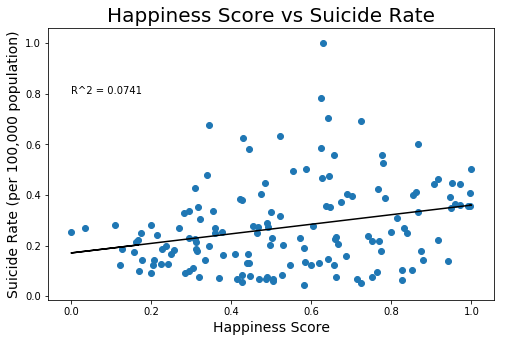

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(residual_df['norm_hap'], residual_df['norm_suc'])
ax.plot(residual_df['norm_hap'], fit, '-k')
plt.text(0, .8, 'R^2 = ' + str(round(r**2, 4)))
plt.title('Happiness Score vs Suicide Rate', fontsize=20)
plt.xlabel('Happiness Score', fontsize=14)
plt.ylabel('Suicide Rate (per 100,000 population)', fontsize=14)
plt.savefig('../outputs/Happiness_Suicide_Scatter.png')
plt.show()